In [1]:
import json
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
from PIL import Image
import scipy.misc
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import transforms


from src import preprocess
from src import patient
from src import model
from src import metrics
from src import postprocess

%load_ext autoreload 
%autoreload 2
%matplotlib inline

In [2]:
data_dir = '/workdir/hassony/data'
train_dir = data_dir + '/Training'
save_dir = data_dir + '/storage'

train_df = pd.read_csv('/workdir/hassony/data/Training.csv')

In [4]:
patch_size = 30
patient_patches = preprocess.extract_all_patches(train_dir, patch_size)

In [5]:
print('{nb_patients} had at least one patch of size {patch_size}'.format(nb_patients=len(patient_patches), patch_size=patch_size))
nbs_patch = []
for patient_name in patient_patches:
    nbs_patch.append(len(patient_patches[patient_name]))
    
print('{nb_patch} patches were extracted in total'.format(nb_patch=np.sum(nbs_patch)))

97 had at least one patch of size 30
441991 patches were extracted in total


In [223]:
train_df

,Patient_ID,HPV/p16_status,Gender,Age_at_diagnosis,Race,Tumor_side,Tumor_subsite,T_category,N_category,AJCC_Stage,Pathological_grade,Smoking_status_at_diagnosis,Smoking_Pack-Years
0,1,1,Male,58,White,L,Tonsil,2,0,II,III,Former,5.0
1,2,0,Female,78,White,R,BOT,3,0,III,II,Former,70.0
2,3,1,Male,57,White,R,Tonsil,1,2b,IV,III,Current,30.0
3,4,1,Female,56,White,R,BOT,2,2b,IV,III,Never,0.0
4,5,1,Female,60,White,L,Tonsil,2,2b,IV,II,Never,0.0
5,6,1,Male,66,White,R,BOT,1,1,III,III,Never,0.0
6,7,1,Female,72,White,L,BOT,4,0,IV,II,Former,26.0
7,9,0,Female,71,White,L,Tonsil,1,2a,IV,I,Former,50.0
8,11,1,Male,50,White,L,BOT,3,2b,IV,III,Current,30.0
9,12,1,Male,54,White,R,BOT,2,2c,IV,II,Former,60.0


In [6]:
pkl.dump(patient_patches, open(save_dir +
                                '/train_patient_patches_size{size}.pkl'.format(size=patch_size),
                                'wb'))


In [7]:
patient_patches = pkl.load( open(save_dir + '/train_patient_patches_size{size}.pkl'.format(size=patch_size), 'rb'))

In [8]:
# Get hpv-positive and hpv-negative patients
pos_patients = patient.get_patients_by_rec(train_df, patient_patches.keys(), patient_patches, 1)
neg_patients = patient.get_patients_by_rec(train_df, patient_patches.keys(), patient_patches, 0)
print('{0} negative hpv patients'.format(len(neg_patients)))
print('{0} positive hpv patients'.format(len(pos_patients)))

15 negative hpv patients
35 positive hpv patients


In [9]:
# Create a train-test-split with same number of negative and positive hpv patients in each set

# Insure test-train split is consistent
np.random.seed(2)
    
train_list, test_list = model.make_train_test_lists(pos_patients, neg_patients)
print('train patients : {0}'.format(train_list))
print('test patients : {0}'.format(test_list))

train patients : [49, 51, 111, 44, 121, 139, 1, 78, 48, 12, 64, 136, 107, 99, 46, 30, 38, 24, 273, 174, 143, 285, 2, 313]
test patients : [26, 116, 37, 79, 153, 82, 122, 70, 23, 39, 150, 137, 71, 47, 84, 43, 54, 57, 312, 13, 196, 15, 194, 22]


In [10]:
# Extract patches and targets as list of tensors and list of int respectively
train_patches, train_targets = model.create_patch_target(train_list, patient_patches, train_df)
test_patches, test_targets = model.create_patch_target(test_list, patient_patches, train_df)


In [11]:
print('Extracted {patch_nb} patches for training'.format(patch_nb=len(train_patches)))
print('Extracted {patch_nb} patches for testing'.format(patch_nb=len(test_patches)))

Extracted 191511 patches for training
Extracted 249405 patches for testing


In [12]:
mean_patch = model.get_mean_patch(train_patches)

In [13]:
np.mean(mean_patch.numpy())
np.max(mean_patch.numpy())

1097.5607

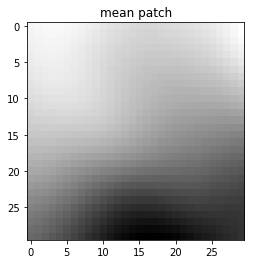

In [14]:
mean_patch
plt.imshow(mean_patch.numpy(), cmap='gray')
plt.title('mean patch')
plt.show()


In [15]:
train_target_tensors, train_patch_tensors = model.create_balanced_tensors(train_targets, train_patches, disp=True)
test_target_tensors, test_patch_tensors = model.create_balanced_tensors(test_targets, test_patches, disp=True)

# train_target_tensors, train_patch_tensors = model.create_balanced_tensors(test_targets, test_patches, disp=True)
# test_target_tensors, test_patch_tensors = model.create_balanced_tensors(train_targets, train_patches, disp=True)


87573 positive patches
103938 negative patches
133163 positive patches
116242 negative patches


In [16]:
print(train_patch_tensors.size())
print(test_patch_tensors.size())

torch.Size([175146, 1, 30, 30])
torch.Size([232484, 1, 30, 30])


In [17]:
batch_size = 10
train_dataset = torch.utils.data.TensorDataset(train_patch_tensors, train_target_tensors)
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

test_dataset = torch.utils.data.TensorDataset(test_patch_tensors, test_target_tensors)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
print(len(train_loader), 'training samples')
print(len(test_loader), 'training samples')

17515 training samples
23249 training samples


In [18]:
class Convnet(nn.Module):
    """
    takes patches of size 25 as input
    """
    def __init__(self, patch_size, fc_neuron_count=32):
        self.size_before_fc = self.get_size_after_conv(patch_size)
        super(Convnet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.drop = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(64*(self.size_before_fc**2), fc_neuron_count)
        self.fc2 = nn.Linear(fc_neuron_count, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x , 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.conv3(x)
        x = F.relu(F.max_pool2d(x, 2))
        x = x.view(-1, 64*(self.size_before_fc**2))
        x = F.relu(self.fc1(x))  
#         x = self.drop(x)
        x = F.softmax(self.fc2(x))
        return x

    def get_size_after_conv(self, initial_size):
        final_size = initial_size
        # first conv bloc
        final_size = (final_size - 2)//2
        # second conv bloc
        final_size = (final_size - 2)//2
        # third conv bloc
        final_size = (final_size - 2)//2
        return final_size

In [19]:
def train_net(dataloader, net, loss_criterion, mean_patch, optimizer, learn=True):
    running_loss = 0.0
    prediction = []
    target = []
    for i, data_item in enumerate(dataloader, 0):
        # get the inputs
        inputs, labels = data_item

        # Remove mean patch from current patch
        inputs = inputs - mean_patch.repeat(inputs.size()[0], 1, 1, 1)
        labels = labels.squeeze()

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        for label in labels:
            if(label.data[0]==1):
                target.append(1)
            else:
                target.append(0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        loss = loss_criterion(outputs, labels)

        # if learning  backward + optimize
        if (learn):
            loss.backward()        
            optimizer.step()

        running_loss += loss.data[0]

        for output in outputs:
            if(output.data[0]>0.5):
                prediction.append(1)
            else:
                prediction.append(0)
        # If network currently learning
    print(len(target))
    return prediction, target, running_loss


In [ ]:
def plot_histogram(values, bin_nb=50):
    hist, bins = np.histogram(values, bin_nb=50)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.show()

In [ ]:
def simulation(dataloader, test_dataloader, net, loss_criterion, mean_patch, epochNb, learning_rate, plot_hists=True):
    
    # Initialize performance arrays
    train_losses = np.zeros(epochNb)
    train_accuracies = np.zeros(epochNb)
    test_losses = np.zeros(epochNb)
    test_accuracies = np.zeros(epochNb)

    train_learning = False
    optimizer = torch.optim.Adam(net.parameters(), learning_rate)
    for epoch in range(epochNb): # loop over the dataset multiple times
        if (epoch>0):
            train_learning = True

        # train
        prediction, target, train_loss = train_net(dataloader, net, loss_criterion, mean_patch,
                                                   optimizer, learn=train_learning)
        train_conf_mat, train_acc = metrics.get_metrics(target, prediction)
        train_losses[epoch] = train_loss

        # Save results
        train_accuracies[epoch] = train_acc
        train_losses[epoch] = train_loss
        
        # print epoch train results
        print('Training loss: {los}'.format(los=train_loss))
        print('Training confusion matrix')
        print(train_conf_mat)
        print('Training accuracy : ', train_acc) 

        # plot histogram of predictions
        if(plot_hists):
            plot_histogram(prediction)
            plot_histogram(target)

        # test
        test_prediction, test_target, test_loss = train_net(test_dataloader, net, loss_criterion, mean_patch,
                                                            optimizer, learn=False)
        test_conf_mat, test_acc = metrics.get_metrics(test_target, test_prediction)
        test_losses[epoch] = test_loss

        # Save results
        test_accuracies[epoch] = test_acc
        test_losses[epoch] = test_loss
        
        # print epoch train results
        print('Testing loss: {los}'.format(los=test_loss))
        print('Testing confusion matrix')
        print(test_conf_mat)
        print('Testing accuracy : ', test_acc) 
        
                # plot histogram of predictions
        if(plot_hists):
            plot_histogram(test_prediction)
            plot_histogram(test_target)
        
    return train_losses, test_losses, train_accuracies, test_accuracies

In [ ]:
torch.manual_seed(3)
net_model_2 = Convnet(patch_size, fc_neuron_count=64)

bce_criterion = nn.BCELoss()
epoch = 10
learning_rate = 0.000001
momentum = 0.9
train_losses, test_losses, train_accuracies, test_accuracies = simulation( test_loader, train_loader, net_model_2, bce_criterion, mean_patch, epoch, learning_rate)

232484
Training loss: 67944.46211242117
Training confusion matrix
[[ 110200.  113684.]
 [   6042.    2558.]]
Training accuracy :  0.48501402247036357
175146
Testing loss: 50562.51132222265
Testing confusion matrix
[[ 83671.  86195.]
 [  3902.   1378.]]
Testing accuracy :  0.48558916561040505
232484
Training loss: 31056.912077762187
Training confusion matrix
[[ 62649.  56513.]
 [ 53593.  59729.]]
Training accuracy :  0.5263932141566732
175146
Testing loss: 19694.496164008975
Testing confusion matrix
[[ 31656.  23388.]
 [ 55917.  64185.]]
Testing accuracy :  0.5472063307183721
232484
Training loss: 21993.779084190726
Training confusion matrix
[[ 56234.  36695.]
 [ 60008.  79547.]]
Training accuracy :  0.5840444933844909
175146
Testing loss: 16642.940798208117
Testing confusion matrix
[[ 38363.  25153.]
 [ 49210.  62420.]]
Testing accuracy :  0.5754227901293778
232484
Training loss: 16514.710169039667
Training confusion matrix
[[ 64662.  31964.]
 [ 51580.  84278.]]
Training accuracy :  0.

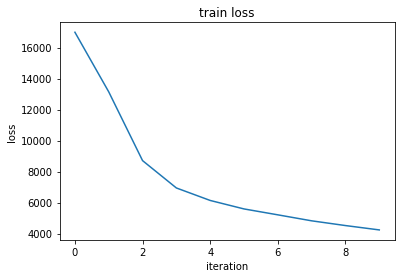

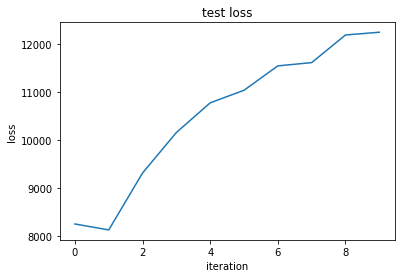

In [242]:
plt.plot(train_losses)
plt.title('train loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()
plt.plot(test_losses)
plt.title('test loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

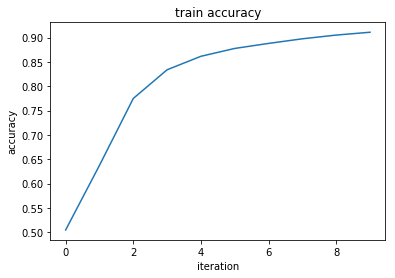

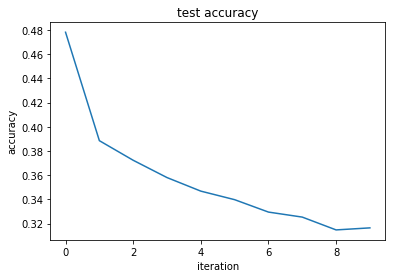

In [243]:
plt.plot(train_accuracies)
plt.title('train accuracy')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()
plt.plot(test_accuracies)
plt.title('test accuracy')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

In [44]:
def make_predictions(net, patient_patches, fill_with=True, fill_value=1, binary=False):
    """
    Computes predictions as the mean score for all the patient's patches
    :param binary: converts real scores to binary with 0.5 threshold
    :param fill_with: If no prediction is available, still make prediction
    :param fill_value: value for default prediction
    :returns: predictions for each patient as dic {patient: score, ...}
    """
    prediction_dic = {}
    for key, patches in patient_patches.items():
        print(key)
        if(len(patches)):
            patch_scores = []
            for patch_id in range(patches.shape[0]):
                tensor_patch = torch.Tensor(patches[patch_id, ])
                # Reshape to add batch dimension
                tensor_patch = tensor_patch.view(1, 1, tensor_patch.size(0), tensor_patch.size(1))
                variable_patch = Variable(tensor_patch)
                prediction = net(variable_patch)
                for output in prediction:
                    patch_scores.append(output.data[0])
            print(np.mean(patch_scores))
            if(binary):
                if (np.mean(patch_scores)>0.5):
                    prediction_dic[key] = 1
                else:
                    prediction_dic[key] = 0
            else:
                prediction_dic[key] = np.mean(patch_scores)
        else:
            if(fill_with):
                prediction_dic[key]=fill_value
    return prediction_dic

In [45]:
hpv_dic = patient.get_hpv_status_dic(train_df)

In [47]:
patient_predictions = make_predictions(net_model, patient_patches, fill_with=True, fill_value=0.5)

1
0.385358872946
2
0.503597642136
4
5
6
7
9
12
0.614906883429
13
0.554334773505
15
0.512259072876
16
273
0.443980078652
18
20
22
0.636717382124
23
0.558736347687
24
0.131156037562
25
26
0.597852684759
29
30
0.520090579987
31
32
34
37
0.298286326631
38
0.369772802749
39
0.580038755074
41
42
43
0.695808055003
44
0.617848691074
45
46
0.602636479253
47
0.698282645394
48
0.568188114948
49
0.388564575767
51
0.379673946594
54
0.593264546245
55
56
313
0.456905517803
59
60
61
62
63
64
0.584898643071
65
66
68
70
0.500168736363
71
0.553856806402
73
75
78
0.545109784603
79
0.383263259552
80
312
0.534791507425
82
0.513500298719
83
84
0.503109460682
57
0.480391783001
88
93
94
95
99
0.255689096183
100
102
105
107
0.597458367164
111
0.582452896514
115
116
0.587703931899
120
121
0.581164422788
122
0.344592000189
125
132
133
135
136
0.481819126917
137
0.23986502177
139
0.541962575048
140
142
143
0.539900781579
146
150
0.593955427408
153
0.399103506214
159
170
0.437118086128
174
0.564510444658
285
0.4654

In [48]:
patient_predictions_list = []
hpv_list = []
for patient_id, pred in patient_predictions.items():
    if (patient_id in test_list):
        patient_predictions_list.append(pred)
        hpv_status = hpv_dic[patient_id]
        hpv_list.append(hpv_status)

In [60]:
patient_conf, patient_acc = metrics.get_metrics(hpv_list, patient_predictions_list)

[0.55433477350522442, 0.51225907287561712, 0.63671738212391482, 0.55873634768664127, 0.59785268475880493, 0.29828632663081434, 0.58003875507405545, 0.69580805500348408, 0.69828264539440477, 0.59326454624533653, 0.50016873636334547, 0.55385680640217516, 0.38326325955228951, 0.53479150742492398, 0.51350029871887237, 0.50310946068182116, 0.48039178300074098, 0.58770393189929782, 0.34459200018944053, 0.23986502177001018, 0.59395542740821838, 0.39910350621359525, 0.54915094215955051, 0.57399676866459504]
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]


In [61]:
print(patient_conf)
print(patient_acc)

[[  1.   5.]
 [  6.  12.]]
0.5416666666666666


In [62]:
test_dir = data_dir + '/Test'

test_df = pd.read_csv('/workdir/hassony/data/Test.csv')

In [63]:
test_patient_patches = preprocess.extract_all_patches(test_dir, patch_size, display=True)

301
230
233
271
74
236
274
165
239
277
168
310
201
204
242
207
245
283
248
286
177
289
14
210
213
251
216
254
145
219
257
148
295
298
190
189
222
225
263
228
266
157
269
302
231
305
234
237
275
278
311
202
314
file /workdir/hassony/data/Test/Case_314/CT1.2.840.113696.347054.500.4451859.20110105100658.0.4.48.dcm not found!
file /workdir/hassony/data/Test/Case_314/CT1.2.840.113696.347054.500.4451859.20110105100658.0.4.49.dcm not found!
file /workdir/hassony/data/Test/Case_314/CT1.2.840.113696.347054.500.4451859.20110105100658.0.4.50.dcm not found!
file /workdir/hassony/data/Test/Case_314/CT1.2.840.113696.347054.500.4451859.20110105100658.0.4.51.dcm not found!
file /workdir/hassony/data/Test/Case_314/CT1.2.840.113696.347054.500.4451859.20110105100658.0.4.52.dcm not found!
file /workdir/hassony/data/Test/Case_314/CT1.2.840.113696.347054.500.4451859.20110105100658.0.4.53.dcm not found!
file /workdir/hassony/data/Test/Case_314/CT1.2.840.113696.347054.500.4451859.20110105100658.0.4.54.dcm not

In [134]:
len(test_patient_patches)
for pat, patches in test_patient_patches.items():
    print(len(patches))

0
0
0
0
7
0
0
7
3956
3
0
21957
23771
61218
542
0
64
3418
4546
34
620
2282
0
0
12127
0
1
107
751
0
0
1547
0
68
1232
5368
333
649
65
4384
0
1016
0
31
2783
57228
65
0
0
0
262
0
5292
12885
0
11
1235
0
0
0
931
6296
0
259
61015
0
0
0
50
0
0
0
3
109458
0
0
0
40824
10040
404
0
2525
0
0
3704
0
0
0
6
0
0
0
0
12436
0
1363
848
844
9676
0
1284
661
0
15572
1420
0
49
0
0
0
1004
2
3386
0
2052
3
206856


In [65]:
test_patient_predictions = make_predictions(net_model, test_patient_patches, fill_with=True, fill_value=0.5)


256
257
258
259
260
0.500290372542
261
263
8
0.582406857184
265
0.5183364402
266
0.589952806632
267
268
0.527355072402
269
0.505389793238
14
0.557099905672
272
0.58286509946
274
275
0.852410214953
276
0.566289104522
277
0.57124107348
278
0.531779891428
279
0.453830484271
280
0.501638747506
281
282
283
0.35543714596
284
286
0.199537411332
287
0.483994857382
288
0.555682741572
289
290
291
0.54437854894
292
294
0.494071566445
295
0.572698294995
296
0.591433862823
297
0.383340130203
298
0.52970971918
247
0.363850104809
300
0.546262368973
301
302
0.507274680358
303
304
0.523740831883
305
0.253145514269
306
0.552308300138
307
0.571678267362
308
309
310
311
0.752725754019
314
315
0.325175821449
53
0.452752430241
74
81
0.65141078017
270
0.487847338719
58
96
110
134
0.178159297922
145
0.618667449277
148
149
0.429202944035
155
0.44676387813
162
165
241
172
0.629130808115
173
176
177
178
0.685462613901
179
0.510763157393
187
192
200
202
0.528101754638
203
0.540220396196
204
0.478306147696
207
208

In [66]:
test_patient_list = list(test_df.Patient_ID)

In [67]:
len(test_patient_list)

165

In [131]:
completed_test = {}
for patient_id in test_patient_list:
    if patient_id in test_patient_predictions:
        completed_test[patient_id] = test_patient_predictions[patient_id]
    else:
        completed_test[patient_id] = np.random.random()

In [132]:
postprocess.write_predictions(completed_test, 'real-results-size-30-it-2-torchseed-4-lr-0-0001-mom-0-9-drop.csv')

In [284]:
test_df

,Patient_ID,HPV/p16_status,Gender,Age_at_diagnosis,Race,Tumor_side,Tumor_subsite,T_category,N_category,AJCC_Stage,Pathological_grade,Smoking_status_at_diagnosis,Smoking_Pack-Years
0,8,NaN,Male,77,White,R,Tonsil,1,2a,IV,NaN,0.0,Never
1,10,NaN,Male,50,White,R,BOT,3,3,IV,II,0.0,Never
2,14,NaN,Male,59,White,R,BOT,4,2c,IV,NaN,30.0,Former
3,33,NaN,Male,53,White,L,Tonsil,1,2c,IV,III,62.0,Current
4,40,NaN,Male,57,White,R,BOT,3,2c,IV,NaN,50.0,Former
5,53,NaN,Male,64,White,L,Other,4,2c,IV,II,80.0,Former
6,58,NaN,Male,58,White,L,GPS,2,2b,IV,II,44.0,Current
7,74,NaN,Male,69,White,R,GPS,2,2b,IV,II-III,30.0,Former
8,81,NaN,Female,60,Black,R,BOT,2,2b,IV,II,25.0,Current
9,96,NaN,Male,53,White,R,BOT,1,3,IV,II,1.0,Former


In [129]:
completed_test = {}
for patient_id in test_patient_list:
    completed_test[patient_id] = np.random.random()

In [130]:
completed_test

{8: 0.2637431768256049,
 10: 0.2432629012054629,
 14: 0.4497167759791172,
 33: 0.8441526586363612,
 40: 0.03685802596516319,
 53: 0.13353751060512975,
 58: 0.1706551218806701,
 74: 0.7597519856860848,
 81: 0.6165804042977775,
 96: 0.5706772854040005,
 110: 0.49502962210555135,
 129: 0.09544318948738317,
 134: 0.21296330555536302,
 145: 0.49506094872740314,
 147: 0.3443126986067724,
 148: 0.6050499547149475,
 149: 0.5991282717070974,
 151: 0.0911651081107363,
 155: 0.6707135209430929,
 157: 0.23123225182422136,
 160: 0.270001088819691,
 161: 0.0015739637238899595,
 162: 0.47457877336348697,
 163: 0.2519839493549434,
 165: 0.3835633526422807,
 166: 0.0644426310939179,
 167: 0.4358919238854799,
 168: 0.8990298447237652,
 171: 0.8821194976318654,
 172: 0.4791678706106528,
 173: 0.4405120697863113,
 175: 0.19667647755675555,
 176: 0.5647962079724167,
 177: 0.5892835326781358,
 178: 0.12506017464014807,
 179: 0.14303377945124762,
 180: 0.9056043959040623,
 181: 0.7021088094687254,
 182: 0.48

ROC AUC: 0.8846153846153846


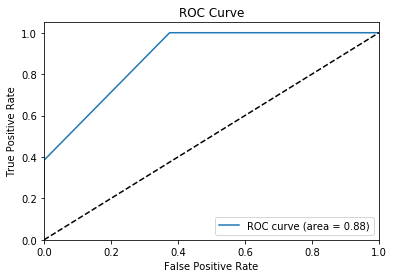

In [123]:
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split

# preds_ = [0.1, 0.2, 0, 0, 0, 0.8, 0.9, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ]
preds_ = [0.1, 0.2, 0, 0, 0, 0.8, 0.9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ]
preds_ = [0.1, 0.2, 0, 0, 0, 0.8, 0.9, 1, 1, 1,  0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5 ]
golds_ = [0.0, 0.0, 0, 0, 0, 1.0, 1.0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1 ]
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(golds_, preds_)
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print('ROC AUC: {0}'.format(roc_auc))
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

[0, 1, 1]
[1, 0, 1]
[(0, 1), (1, 0), (1, 1)]


/gpfs/workdir/hassony/virtual-python/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


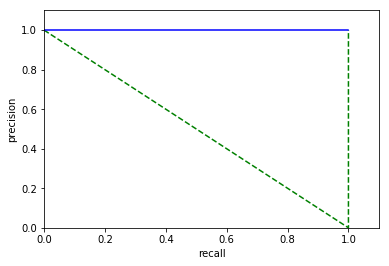

In [119]:
preds = [0, 1, 1]
goldens = [1, 0, 1]
print(preds)
print(goldens)
tuples_ = list(zip(preds, goldens))
print(tuples_)
show_recall_precision(list(zip(preds, goldens)))

In [ ]:
patient_patch